In [1]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 51.3 MB/s eta 0:00:00


In [2]:
 #setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
# make qutip available in the rest of the notebook
from qutip import *
from matplotlib import animation as animation, pyplot as plt, cm
from IPython import display
from IPython.display import HTML




def Opera(dim,S):
    if S==1:
        jj=jmat(1)
        jx,jy,jz=jmat(1)
        jp=jmat(1,'+')
        jm=jmat(1,'-')
        sx = tensor(qeye(dim), jx)
        sy = tensor(qeye(dim), jy)
        sz = tensor(qeye(dim), jz)
        sm = tensor(qeye(dim), jm)
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(3))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(3))
    else:

        sx = tensor(qeye(dim), sigmax())
        sy = tensor(qeye(dim), sigmay())
        sz = tensor(qeye(dim), sigmaz())
        sm = tensor(qeye(dim), sigmam())
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(2))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(2))

    return sm, sp, sx, sy, sz, a, ad, ids






def compute_expectations(states, observables):
    """
    Compute the expectation values of given observables for a list of states.

    Parameters:
    - states: A list of Qobj states, typically the result of a mesolve.
    - observables: A list of Qobj observables for which to compute expectation values.

    Returns:
    - A list of lists, where each sublist contains the expectation values of an observable over time.
    """
    # Initialize a list to store the expectation values for each observable
    expectation_values = [[] for _ in observables]

    # Loop over each state
    for state in states:
        # Loop over each observable
        for i, obs in enumerate(observables):
            # Calculate and store the expectation value
            expectation_values[i].append(qutip.expect(obs, state))

    return expectation_values


def generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sm, sp, include_lasing=False):
    """
    Generate collapse operators based on provided rates and conditions.

    Parameters:
    - gammam: Rate for cavity relaxation and excitation.
    - gammas: Rate for qubit relaxation.
    - gammaa: Rate for additional qubit dynamics.
    - gamma_l: Rate for lasing.
    - n_th_a: Thermal occupation number for cavity.
    - sp_th_a: Thermal occupation number for qubit.
    - a: Annihilation operator for the cavity.
    - sz, sm, sp: Pauli operators or equivalent for the qubit.
    - include_lasing: Boolean to include lasing in the collapse operators.

    Returns:
    - A list of collapse operators.
    """
    c_ops = []
    # Cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    # Cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    # Qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sz)
    rate = gammaa * (1 + sp_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
    rate = gammaa * sp_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sp)
    # Lasing
    if include_lasing:
        rate = gamma_l
        if rate > 0.0:
            c_ops.append(sqrt(rate) * sm)

    return c_ops







def wtp(t, args):
    return wt*(t-T) + wm
# def wtm(t, args):
#     return wt*(t-T) + wm

def wtm(t, args):
    return -wt*t+ wm

def gtm(t, args):
    return g*sqrt(wm/abs(-wt*t + wm))
def gtp(t, args):
    return g*sqrt(wm/abs(wt*(t-T) + wm))


def Temperature(ni,wi):
    return (wi/kb)/(log(1+1/ni))






def evolst(H, psi0, t, cops, observables):
    opts = Options(store_states=True)
    result = mesolve(H, psi0, t, cops, [], args={}, options=opts)


    return result





def Cyclevol(rho0, hamiltonian_time_pairs, c_ops_list, observables):
    """
    Perform a sequence of time evolutions on an initial state with different Hamiltonians
    and return individual heat contributions for each term in the collapse operators.

    Parameters:
    - rho0: Initial state (Qobj)
    - hamiltonian_time_pairs: List of tuples (H, tlist) for each evolution segment
    - c_ops_list: List of lists of collapse operators corresponding to each Hamiltonian
    - observables: List of observables (Qobj) to compute expectation values

    Returns:
    - all_states: Concatenated list of states from all evolution segments
    - all_times: Concatenated array of time points from all evolution segments
    - all_exp_vals: Concatenated expectation values for each observable over time
    - EntropyM: List of von Neumann entropy values for mechanical part over time
    - EntropyS: List of von Neumann entropy values for spin part over time
    - total_Q_terms_list: List of lists of individual heat contributions for each term in the collapse operators
    """
#     all_states = []
    all_times = array([])
    all_exp_vals = [[] for _ in observables]
    current_state = rho0
    EntropyM = []
    EntropyS = []
#     total_Q_terms_list = None  # Changed to None for clearer initialization logic

    for i, ((H, tlist), c_ops) in enumerate(zip(hamiltonian_time_pairs, c_ops_list)):
#         result, exp_vals, Q_terms = evolst(H, current_state, tlist, c_ops, observables)
        result= evolst(H, current_state, tlist, c_ops, observables)

#         all_states.extend(result.states)

#         if i == 0:
#             all_times = array(tlist)
#         else:
#             # Ensure continuity in time by adding the last time from all_times
#             all_times = concatenate((all_times, all_times[-1] + tlist))

#         for j, exp_val in enumerate(exp_vals):
#             all_exp_vals[j].extend(exp_val)

#         for state in result.states:
#             EntropyM.append(entropy_vn(state.ptrace(0), base=e))
#             EntropyS.append(entropy_vn(state.ptrace(1), base=e))

        current_state = result.states[-1]

    return current_state



def CycleCool(rho0, hamiltonian_time_pairs, c_ops_list, observables, Ncycles):

    current_rho = rho0
#     t=array([0])
#     allst=[current_rho]
#     allexp=compute_expectations([rho0], observables)
    rho_mech = current_rho.ptrace(0)
    rho_spin = current_rho.ptrace(1)
    EntropyM=[entropy_vn(rho_mech, base=e)]
    EntropyS=[entropy_vn(rho_spin, base=e)]


    for i in range(Ncycles):

#         if i==0:
#              t=array([0])
        rhoc = Cyclevol(current_rho, hamiltonian_time_pairs, c_ops_list, observables)
#         EntropyM=concatenate((EntropyM,entropyM), axis=0)
#         EntropyS=concatenate((EntropyS,entropyS), axis=0)
#         allst=allst+rhoc
#         allexp=allexp+exp_vals
#         t=concatenate((t, tt + (t[-1] if i > 0 else 0)))
        rho_mech = rhoc.ptrace(0)
        rho_spin = rhoc.ptrace(1)
        EntropyM=[entropy_vn(rho_mech, base=e)]
        EntropyS=[entropy_vn(rho_spin, base=e)]
        current_rho=rhoc
        print(i)

    return rhoc, EntropyM, EntropyS









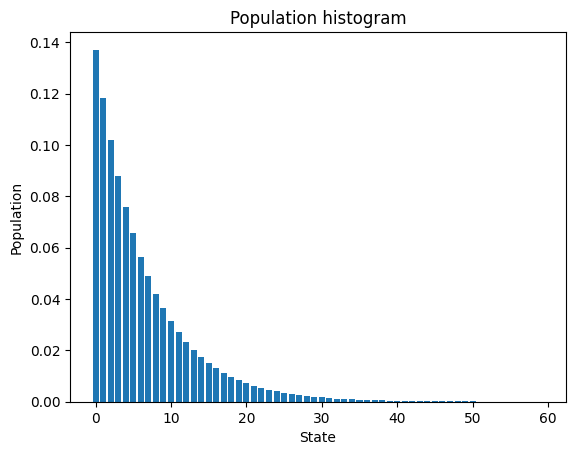

In [3]:
N =60
S=0.5



kb= 20836619120

# wm = 50 * 2 * pi
# fy =  1*10**(6)
# # g  = 3e10 *1e-9* 2 * pi*.22
# g=0.15*wm
# wt = 10000
# T=0.1*pi/(wm)
# wmin=(-wt*T + wm)
# gmin=g*sqrt(wm/(-wt*T + wm))
# fx = 0.5*wmin;
# Delta=3*wmin

wt = 14000

w0 = 50 * 2 * pi
wm = 50 * 2 * pi +wt*pi / w0
T=1*pi / w0;

# fx = 0.5*wm;
fy =  1*10**(6)
gr=0.7*w0
g  =  gr*sqrt(w0/wm)#3e10 *1e-9* 2 * pi*.22


wmin=(-wt*T + wm)
gmin=g*sqrt(wm/(-wt*T + wm))
fx = 0.5*wmin;
Delta=5.8*wmin

######### Operators ##################
sm, sp, sx, sy, sz, a, ad, ids=Opera(N,S)
z = a+ad
p = 1j*(ad-a)
z2 = z**2
p2 = p**2


######### Damping rates for each mode
Qm=10000
gammam = 1*wm/Qm
# gammam = 1*10**(-1)
# gammas = 0.2/(1*10**(-3))
# gammaa = 0.1/(1*10**(-3))
gammas = 1/(2.5*10**(-3))
gammaa = 1/(5*10**(-3))
gamma_l = 1/(10**(-6))
n_th_a = 6.     # avg number of thermal bath excitation
sp_th_a= 0.0001
n_th = n_th_a

c_ops1 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=False)
c_ops2 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=True)


######### Time evolutions ########


Tpy = pi/(2*abs(fy))
tfree = 1*pi/wmin
tfree2 = 2*tfree
# tfree = 5*0.019
# tlase=1*10**(-6)
tlase=5*10**(-5)

# T = tfree + Tpy + tlase
twm=linspace(0,T,500)
tpy = linspace(0, Tpy, 50)
tf1 = linspace(0, tfree, 150)
tf2 = linspace(0, tfree2, 150)
tgl = linspace(0, tlase, 50)


######## Hamiltonians
H    = Delta*(ids-sz)/2 + wm*ad*a - g*(ids-sz)*(a+ad)/2
Hmin = Delta*(ids-sz)/2 + wmin*ad*a - gmin*(ids-sz)*(a+ad)/2

H0tp = [ad*a, wtp]
H0tm = [ad*a, wtm]

Hintp =[0.5*(ids-sz)*(a+ad) , gtp]
Hintm =[0.5*(ids-sz)*(a+ad) , gtm]

Hp = [ Delta*(ids-sz)/2, H0tp, Hintp]
Hm = [ Delta*(ids-sz)/2, H0tm, Hintm]



Hseq=[(Hmin+fx*sx, tf1), (Hmin, tgl)]
c_ops_seq = [c_ops1, c_ops2]


observables =  [ad*a, z, p, z2, p2, a, a**2, sz, sx, sy, Hmin, H]


rho1=steadystate(Hmin, c_ops1)
# rho1=tensor(thermal_dm(N,n_th),ket2dm(basis(2,0)))
# exp1=compute_expectations([rho1], observables)

# Assume 'state' is a Qobj for a density matrix, and we need the diagonal
rho_reduced = rho1.ptrace(0)  # Adjust if tracing over a different subsystem
populations = rho_reduced.diag()

# Prepare the figure
plt.clf()  # Clear the current figure
plt.bar(arange(len(populations)), populations)


# Labeling the plot
plt.title(f'Population histogram')
plt.xlabel('State')
plt.ylabel('Population')
plt.draw()  # Draw the current frame

plt.show()


In [36]:
from scipy.io import savemat
from joblib import Parallel, delayed

# Initialization

Nt = 50
ntimesL = linspace(1, 201, Nt)

# Initialize the array to store energy and phonon number values
ETl = zeros((5, Nt))
nTl = zeros((5, Nt))

# Compute initial E1 and n1
rho1 = steadystate(H, c_ops1)
E1 = expect(H, rho1)
n1 = expect(ad * a, rho1)

# Function to compute the values for each Nc
def compute_for_Nc(ii, ntimes):
    print(f"Processing Tl index {ii}")
    ntimes = int(ntimes)

    wmin = -wt * T + wm
    gmin = g * sqrt(wm / (-wt * T + wm))
    fx = 0.5 * wmin
    Delta = 5.8 * wmin

    # Time evolutions
    tfree = pi / wmin
    twm = linspace(0, T, 500)
    tf1 = linspace(0, tfree, 150)

    Hmin = Delta * (ids - sz) / 2 + wmin * ad * a - gmin * (ids - sz) * (a + ad) / 2

    H0tp = [ad * a, wtp]
    H0tm = [ad * a, wtm]

    Hintp = [0.5 * (ids - sz) * (a + ad), gtp]
    Hintm = [0.5 * (ids - sz) * (a + ad), gtm]

    Hp = [Delta * (ids - sz) / 2, H0tp, Hintp]
    Hm = [Delta * (ids - sz) / 2, H0tm, Hintm]

    Hseq = [(Hmin + fx * sx, tf1), (Hmin, tgl)]
    c_ops_seq = [c_ops1, c_ops2]

    # Evolution and expectation calculations
    result = evolst(Hm, rho1, twm, c_ops1, observables)
    rho2 = result.states
#     Hm_final = Hm[0] + Hm[1][0] * Hm[1][1](twm[-1], None) + Hm[2][0] * Hm[2][1](twm[-1], None)
    E2 = expect(Hmin, rho2[-1])

    rho3, EntropyM, EntropyS = CycleCool(rho2[-1], Hseq, c_ops_seq, observables, ntimes)
    E3 = expect(Hmin, rho3)

    result = evolst(Hp, rho3, twm, c_ops1, observables)
    rho4 = result.states
#     Hp_final = Hp[0] + Hp[1][0] * Hp[1][1](twm[-1], None) + Hp[2][0] * Hp[2][1](twm[-1], None)
    E4 = expect(H, rho4[-1])

    # Compute final E5
    rho5 = steadystate(H, c_ops1)
    E5 = expect(H, rho5)

    # Phonon numbers
    n2 = expect(ad * a, rho2[-1])
    n3 = expect(ad * a, rho3)
    n4 = expect(ad * a, rho4[-1])
    n5 = expect(ad * a, rho5)

    # Return the results
    return [E1, E2, E3, E4, E5], [n1, n2, n3, n4, n5]

# Parallelize the computation for each T
results = Parallel(n_jobs=-1)(delayed(compute_for_Nc)(ii, ntimes) for ii, ntimes in enumerate(ntimesL))

# Unpack the results into ETl and nTl arrays
for ii, (ETl_vals, nTl_vals) in enumerate(results):
    ETl[:, ii] = ETl_vals
    nTl[:, ii] = nTl_vals

# Save the results
data_dict = {
    'Nc': ntimesL,
    'ETl': ETl,
    'nTl': nTl
}

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [40]:
from pathlib import Path


# 2) Save your first dict
savemat("energy_results_coolinga.mat",data_dict, do_compression=True, long_field_names=True)

# 3) Save param3 once (not .mat.mat)
param3 = [N, S, wm, fx, fy, g, Delta, wt, T, tfree, Tpy, tlase, Qm, gammas, gammaa, gamma_l, n_th, sp_th_a]
savemat("param5.mat", {"param5": param3}, do_compression=True, long_field_names=True)

In [41]:
paramNc = [N, S, wm, fx, fy, g, Delta, wt, T, tfree, Tpy, tlase, Qm, gammas, gammaa, gamma_l, n_th, sp_th_a]
savemat( "paramNc.mat",
        {"paramNc": paramNc}, do_compression=True, long_field_names=True)